In [40]:
# standard library imports
import os
import time
from glob import glob
from collections import Counter
from typing import Tuple

# third-party library imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import hashlib
import keras
import tensorflow as tf

# submodule or subpackage imports
from pathlib import Path
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import img_to_array
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [2]:
print("Tensorflow has access to the following devices:")
for device in tf.config.list_physical_devices():
    print(f"- {device}")

Tensorflow has access to the following devices:
- PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
plt.style.use('default')

In [4]:
IMG_PATH = (
    Path().cwd() / Path("data") / Path("brain_tumor_dataset") / Path("formatted_images")
)


In [5]:
def load_images(
    image_path: Path, subfolder: str, image_size: Tuple[int, int] = (120, 120)
) -> Tuple[np.ndarray, np.ndarray, dict]:
    """
    Load images from a given folder and its subfolders, and resize them as numpy arrays.

    Parameters:
        image_path (Path): The root directory that contains the subfolders with images.
        subfolder (str): The name of the subfolder within the root directory to 
                         load images from.
        image_size (Tuple[int, int]): The size (in pixels) to resize the images to. 
                                      Default is (120, 120).

    Returns:
        Tuple[np.ndarray, np.ndarray, dict]: A tuple containing:
            - A numpy array of shape (N, H, W, 3) containing the resized images, where 
              N is the number of images, H and W are the image height and width, and 3 represents 
              the RGB channels.
            - A numpy array of shape (N,) containing the labels for each image, where N is the 
              number of images.
            - A dictionary mapping label indices to label names.
    """
    X = []
    y = []
    labels = dict()

    sub_image_path = image_path / Path(subfolder)

    for i, _path in tqdm(
        enumerate(sorted(sub_image_path.glob("*"))),
        total=len(list(sub_image_path.glob("*"))),
    ):
        labels[i] = str(_path).split("/")[-1]
    for k, v in list(labels.items()):
        img_image_path = Path(sub_image_path) / Path(str(v))
        for img_path in img_image_path.glob("*"):
            img = cv2.imread(str(img_path))
            X.append(img)
            y.append(k)
    X = np.array(X, dtype=object)
    y = np.array(y)
    print(f"{len(X)} images loaded")
    return X, y, labels


In [6]:
X_train, y_train, labels = load_images(IMG_PATH, "TRAIN_IMGS")
X_test, y_test, _ = load_images(IMG_PATH, "TEST_IMGS")
X_val, y_val, _ = load_images(IMG_PATH, "VALIDATION_IMGS")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 6369.48it/s]


165 images loaded


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]


47 images loaded


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]

16 images loaded


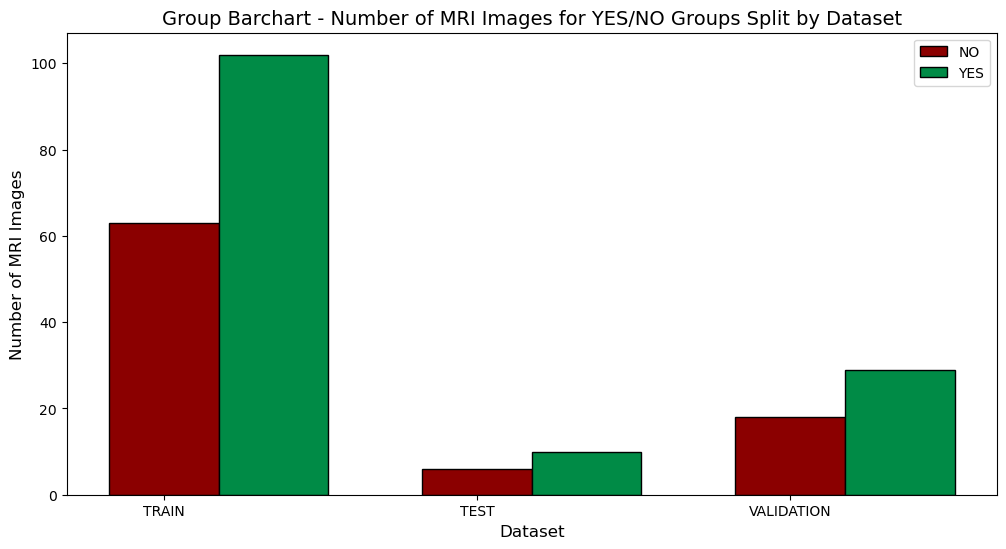

In [7]:
# volume of "Yes" and "No" per dataset.

y = {}
y[0] = []
y[1] = []
for dataset in (y_train, y_val, y_test):
    y[0].append(np.sum(dataset == 0))
    y[1].append(np.sum(dataset == 1))

datasets = ["TRAIN", "TEST", "VALIDATION"]
folders = ["NO", "YES"]
pos = np.arange(len(datasets))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)

plt.bar(pos, y[0], bar_width, color="#8b0000", edgecolor="black")
plt.bar(pos + bar_width, y[1], bar_width, color="#008b46", edgecolor="black")
plt.xticks(pos, datasets)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Number of MRI Images", fontsize=12)
plt.title(
    "Group Barchart - Number of MRI Images for YES/NO Groups Split by Dataset",
    fontsize=14,
)
plt.legend(folders, loc=1)
plt.show()


In [8]:
# plot sample images showing tumor cases and none cases
def plot_image_samples(X: np.ndarray, y: np.ndarray, labels: dict, n: int = 10) -> None:
    """
    Plot a sample of images from a dataset with corresponding labels.

    Parameters:
        X (np.ndarray): A numpy array of shape (N, H, W, C) containing the images, where
                        N is the number of images, H and W are the image height and width,
                        and C is the number of channels.
        y (np.ndarray): A numpy array of shape (N,) containing the labels for each image,
                        where N is the number of images.
        labels (dict): A dictionary mapping label indices to label names.
        n (int): The number of images to plot for each label. Default is 10.

    Returns:
        None
    """
    for i in range(len(labels)):
        imgs = X[np.argwhere(y == i)][:n]
        j = 10
        _i = int(n / j)

        plt.figure(figsize=(18, 3))
        for c, img in enumerate(imgs):
            plt.subplot(_i, j, c + 1)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f"Tumor: {labels[i]}")
        plt.show()


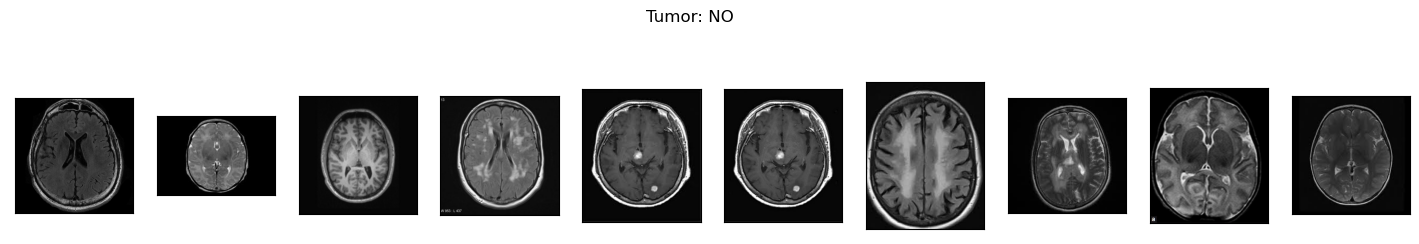

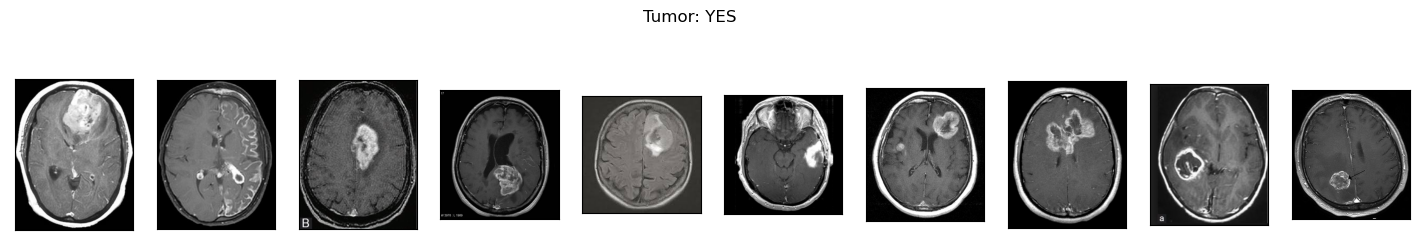

In [9]:
plot_image_samples(X=X_train, y=y_train, labels=labels)


In [10]:
# we can see that the height and width of the images above are of different sizes, we need these to be (224, 224)

image_width_height_ratios = []

for ds in (X_train, X_test, X_val):
    for img in ds:
        image_width_height_ratios.append(round(img.shape[1] / img.shape[0], 1))

Counter(image_width_height_ratios)


Counter({1.0: 61, 1.5: 3, 0.9: 60, 0.8: 82, 1.1: 9, 1.8: 4, 0.7: 8, 1.3: 1})

In [11]:
img = cv2.imread(str(IMG_PATH / Path("TRAIN_IMGS") / Path("YES") / Path("Y163.JPG")))

img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred_grayscale_img = cv2.GaussianBlur(
    grayscale_img, (5, 5), 0
)  # apply a blur on the grayscale image to help separate the brain contours

binary_threshold = cv2.threshold(blurred_grayscale_img, 45, 255, cv2.THRESH_BINARY)[
    1
]  # create a binary threshold to help separate brain and noise
erode_threshold = cv2.erode(
    binary_threshold, None, iterations=2
)  # apply erosion to shrink the amount of brain, increasing the noise
dilate_threshold = cv2.dilate(
    erode_threshold, None, iterations=2
)  # apply dilation to shrink the amount of noise, increasing the brain area

contours = cv2.findContours(
    dilate_threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)  # identify the contours of the brain
grabbed_contours = imutils.grab_contours(contours)
largest_contour = max(
    grabbed_contours, key=cv2.contourArea
)  # if the largest contour is the frame, no cropping is needed

# select the extreme points of the largest contour
extreme_left = tuple(largest_contour[largest_contour[:, :, 0].argmin()][0])
extreme_right = tuple(largest_contour[largest_contour[:, :, 0].argmax()][0])
extreme_top = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])
extreme_bottom = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])

img_contours = cv2.drawContours(img.copy(), [largest_contour], -1, (0, 255, 255), 4)

# add the extreme contour points to the image
img_points_added = cv2.circle(img_contours.copy(), extreme_left, 8, (0, 0, 255), -1)
img_points_added = cv2.circle(img_points_added, extreme_right, 8, (0, 255, 0), -1)
img_points_added = cv2.circle(img_points_added, extreme_top, 8, (255, 0, 0), -1)
img_points_added = cv2.circle(img_points_added, extreme_bottom, 8, (255, 255, 0), -1)

# crop image using contour points
cropped_img = img[
    extreme_top[1] : extreme_bottom[1], extreme_left[0] : extreme_right[0]
].copy()


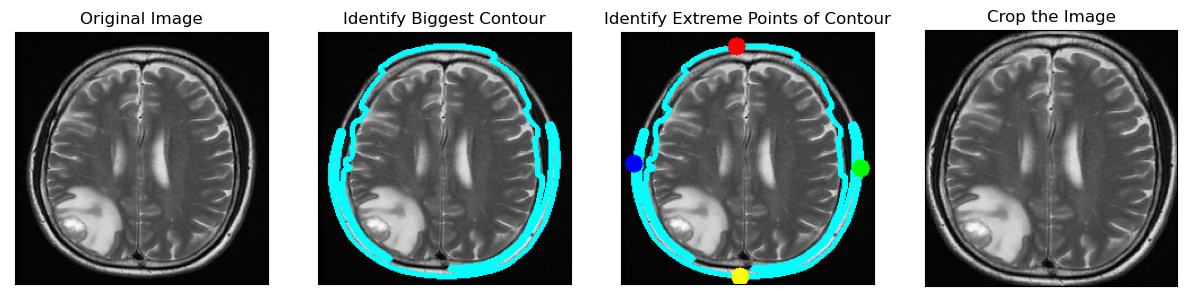

In [12]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.subplot(1, 4, 2)
plt.imshow(img_contours)
plt.xticks([])
plt.yticks([])
plt.title("Identify Biggest Contour")
plt.subplot(1, 4, 3)
plt.imshow(img_points_added)
plt.xticks([])
plt.yticks([])
plt.title("Identify Extreme Points of Contour")
plt.subplot(1, 4, 4)
plt.imshow(cropped_img)
plt.xticks([])
plt.yticks([])
plt.title("Crop the Image")
plt.show()


In [13]:
# to fix this problem, we need to crop out the brain within the image
def crop_images(dataset_name: np.ndarray) -> np.ndarray:
    """
    Crop images to remove the background and focus on the main object in the image.

    Parameters:
        dataset_name (np.ndarray): A numpy array of shape (N, H, W, C) containing the images to be cropped, where N is the number of images, H and W are the image height and width, and C is the number of channels.

    Returns:
        np.ndarray: A numpy array of shape (N, H', W', C) containing the cropped images, where N is the number of images, H' and W' are the cropped image height and width, and C is the number of channels.
    """

    new_dataset = []

    for img in dataset_name:
        grayscale_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        blurred_grayscale_image = cv2.GaussianBlur(grayscale_image, (5, 5), 0)

        binary_threshold = cv2.threshold(
            blurred_grayscale_image, 45, 255, cv2.THRESH_BINARY
        )[1]
        erode_threshold = cv2.erode(binary_threshold, None, iterations=2)
        dilate_threshold = cv2.dilate(erode_threshold, None, iterations=2)

        contours = cv2.findContours(
            dilate_threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        grabbed_contours = imutils.grab_contours(contours)
        largest_contour = max(grabbed_contours, key=cv2.contourArea)

        extreme_left = tuple(largest_contour[largest_contour[:, :, 0].argmin()][0])
        extreme_right = tuple(largest_contour[largest_contour[:, :, 0].argmax()][0])
        extreme_top = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])
        extreme_bottom = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])

        cropped_img = img[
            extreme_top[1] : extreme_bottom[1], extreme_left[0] : extreme_right[0]
        ].copy()
        new_dataset.append(cropped_img)

    return np.array(new_dataset, dtype=object)


In [14]:
X_train_original = X_train.copy()
X_train = crop_images(X_train)

X_test_original = X_test.copy()
X_test = crop_images(X_test)

X_val_original = X_val.copy()
X_val = crop_images(X_val)


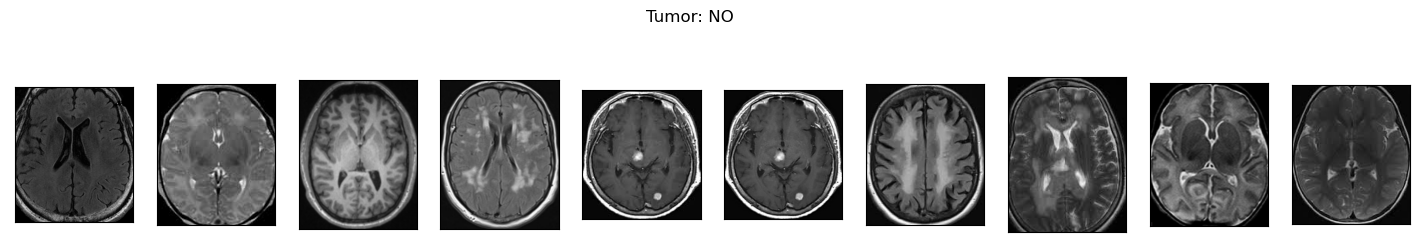

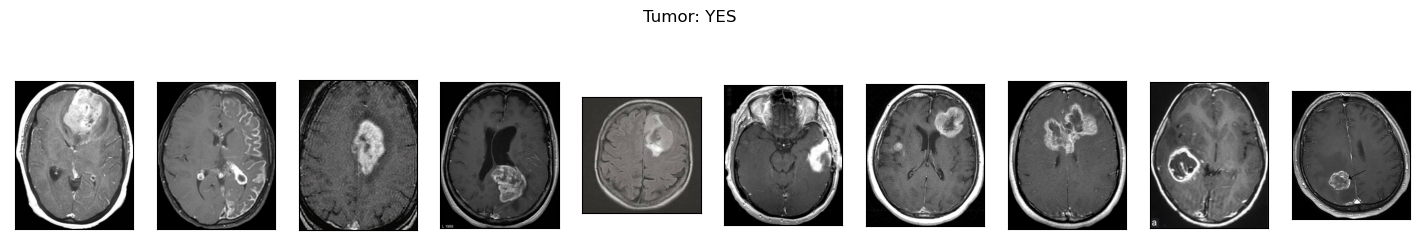

In [15]:
plot_image_samples(X=X_train, y=y_train, labels=labels)


In [16]:
def create_folder_structure() -> None:
    """
    Create a folder structure for storing images in the project.
    
    The function creates a main `cropped_images` folder, and three subfolders
    inside it: `TRAIN_IMGS`, `TEST_IMGS`, and `VALIDATION_IMGS`.
    Each of these subfolders will contain two subfolders called `YES` and `NO`.
    
    Returns:
        None
    """
    current_wd = Path().cwd()
    image_folder = (
        current_wd
        / Path("data")
        / Path("brain_tumor_dataset")
        / Path("cropped_images")
    )

    train_folder = image_folder / Path("TRAIN_IMGS")
    test_folder = image_folder / Path("TEST_IMGS")
    validation_folder = image_folder / Path("VALIDATION_IMGS")

    yes_folder = Path("YES")
    no_folder = Path("NO")

    folders = [train_folder, test_folder, validation_folder]
    sub_folders = [yes_folder, no_folder]

    for f in folders:
        if not f.exists():
            f.mkdir(parents=True)
            print(f"Folder - {str(f).split('/')[-1]} created.")
            for sf in sub_folders:
                sub_folder_dir = f / Path(sf)
                if not sub_folder_dir.exists():
                    sub_folder_dir.mkdir(parents=True)
                    print(f"SubFolder - {str(sf).split('/')[-1]} created.")
                else:
                    print(f"SubFolder - {str(sf).split('/')[-1]} already exists.")
        else:
            print(f"Folder - {str(f).split('/')[-1]} already exists.")


In [17]:
create_folder_structure()

Folder - TRAIN_IMGS already exists.
Folder - TEST_IMGS already exists.
Folder - VALIDATION_IMGS already exists.


In [18]:
def save_new_images(X: np.ndarray, y: np.ndarray, dataset_class: str) -> None:
    """
    Save a set of images to a specified folder.

    Parameters:
        X (np.ndarray): A numpy array of shape (N, H, W, C) containing the images 
                        to be saved, where N is the number of images, H and W are the image 
                        height and width, and C is the number of channels.
        y (np.ndarray): A numpy array of shape (N,) containing the labels for each image, 
                        where N is the number of images.
        dataset_class (str): The name of the dataset class to which the images 
                             belong (e.g. 'TRAIN', 'TEST', 'VALIDATION').

    Returns:
        None
    """
    image_folder = (
        Path().cwd()
        / Path("data")
        / Path("brain_tumor_dataset")
        / Path("cropped_images")
    )

    for i, (img, class_int) in enumerate(zip(X, y)):
        if class_int == 0:
            folder_dir = image_folder / Path(f"{dataset_class}_IMGS") / Path("NO")
            cv2.imwrite(f"{folder_dir}/{str(i)}.jpg", img)
        else:
            folder_dir = image_folder / Path(f"{dataset_class}_IMGS") / Path("YES")
            cv2.imwrite(f"{folder_dir}/{str(i)}.jpg", img)


In [19]:
save_new_images(X=X_train, y=y_train, dataset_class="TRAIN")
save_new_images(X=X_test, y=y_test, dataset_class="TEST")
save_new_images(X=X_val, y=y_val, dataset_class="VALIDATION")


In [20]:
# remove duplicate images (compare their pixels)

image_folder = (
    Path().cwd() / Path("data") / Path("brain_tumor_dataset") / Path("cropped_images")
)

dupes = []
hash_keys = {}

parent_folder = ["TEST_IMGS", "TRAIN_IMGS", "VALIDATION_IMGS"]
child_folder = ["NO", "YES"]

for pf in parent_folder:
    for cf in child_folder:
        _folder_path = image_folder / Path(pf) / Path(cf)
        for i, image in enumerate(_folder_path.glob("*")):
            if image.is_file():
                img_array = np.array(cv2.imread(str(image)), dtype=object)
                file_hash = hashlib.md5(img_array).hexdigest()
                if file_hash not in hash_keys:
                    hash_keys[file_hash] = i
                else:
                    dupes.append((f"{i}: {image}", f"{hash_keys[file_hash]}: {image}"))

print(f"Total number of duplicated images: {len(dupes)}")

for si, di in dupes:
    os.remove(di.split(": ")[1])


Total number of duplicated images: 0


In [21]:
def preprocess_imgs(set_name: np.ndarray, img_size: Tuple[int, int]) -> np.ndarray:
    """
    Resize and apply VGG-16 preprocessing to a set of images.

    Parameters:
        set_name (np.ndarray): A numpy array of shape (N, H, W, C) containing the
                               images to be preprocessed, where N is the number of images,
                               H and W are the image height and width, and C is the
                               number of channels.
        img_size (Tuple[int, int]): The size (in pixels) to resize the images to.

    Returns:
        np.ndarray: A numpy array of shape (N, H', W', C) containing the preprocessed images,
                    where N is the number of images, H' and W' are the resized image height
                    and width, and C is the number of channels.
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [22]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=(224, 224))
X_test_prep = preprocess_imgs(set_name=X_test, img_size=(224, 224))
X_val_prep = preprocess_imgs(set_name=X_val, img_size=(224, 224))


In [23]:
# augment data to increase the number of samples for model training

TRAIN_DIR = IMG_PATH.parent / Path("cropped_images") / Path("TRAIN_IMGS")
TEST_DIR = IMG_PATH.parent / Path("cropped_images") / Path("TEST_IMGS")

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [24]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    seed=1234,
)


validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode="rgb",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    seed=1234,
)


Found 165 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


In [25]:
vgg = VGG16(
    include_top=False,
    input_shape=(224, 224) + (3,),
)


Metal device set to: Apple M1 Pro


2022-12-27 20:51:26.666790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-27 20:51:26.666891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
def plot_feature_map(X_val_prep: list, index: int) -> None:
    """
    Plot the feature map of the first convolutional layer for the specified
    image in the given list.

    Parameters:
    X_val_prep (list): A list of preprocessed images.
    index (int): The index of the image to plot the feature map for.
    """
    f = plt.figure(figsize=(16, 16))
    model = VGG16()
    model = Model(inputs=model.inputs, outputs=model.layers[1].output)
    model.summary()
    img = img_to_array(X_val_prep[index])
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feature_maps = model.predict(img)
    square = 8
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix - 1], cmap="viridis")
            ix += 1
    plt.show()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 43ms/step


2022-12-27 20:51:34.470931: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-27 20:51:34.499488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


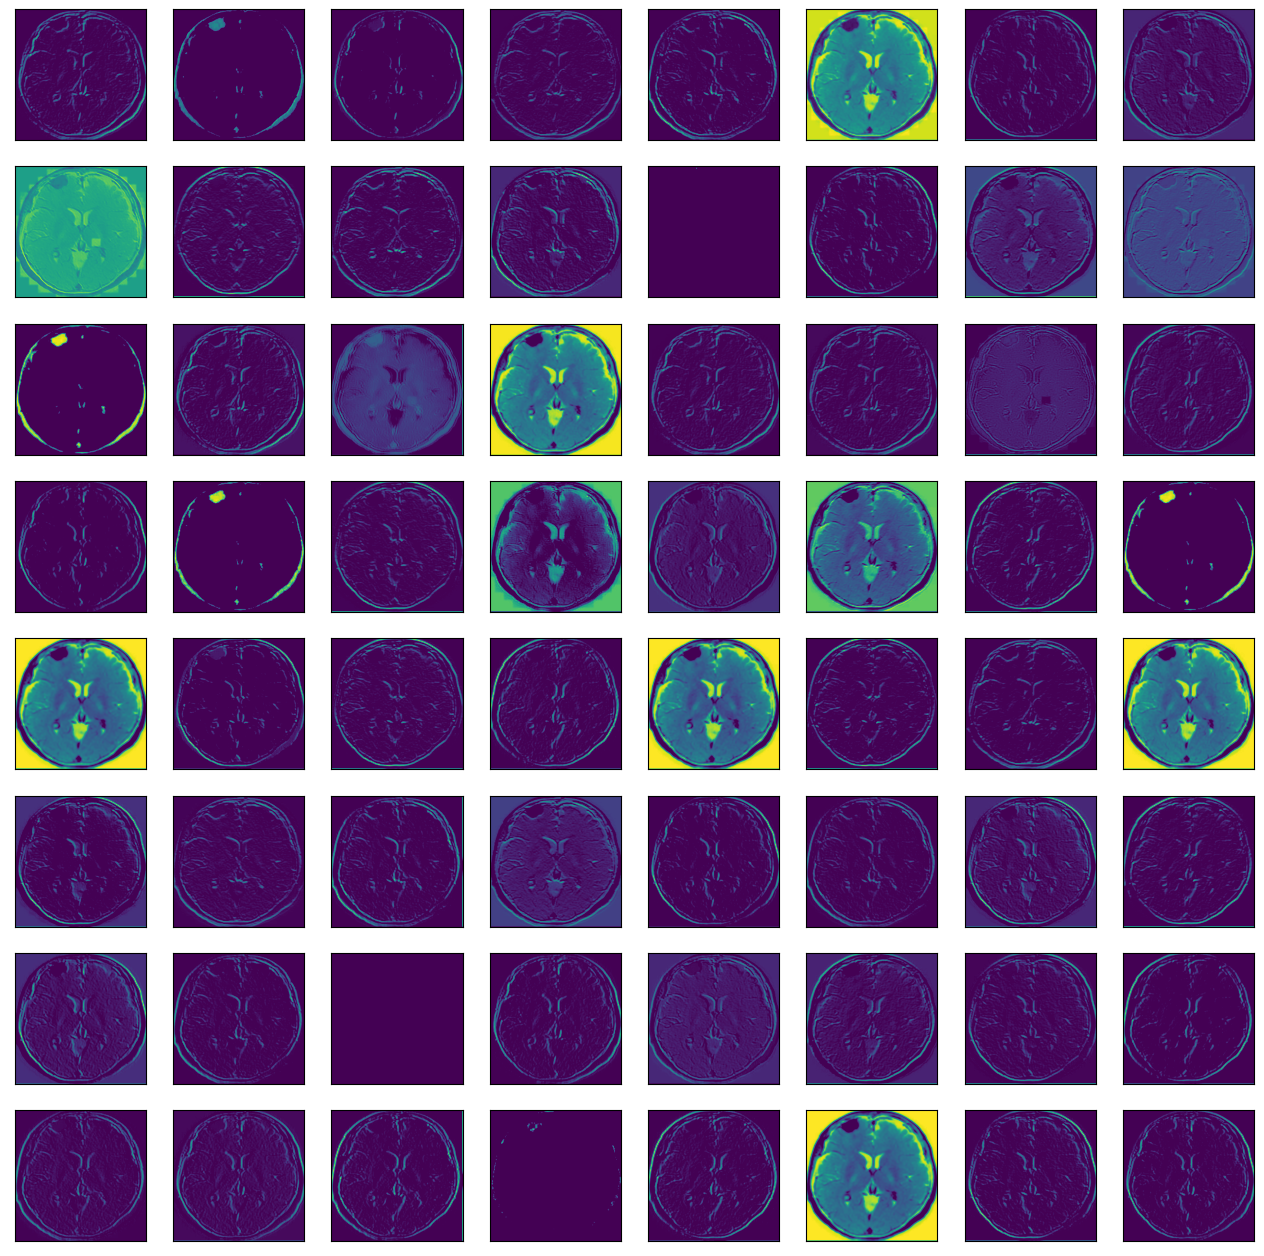

In [27]:
plot_feature_map(X_val_prep, 15)

In [28]:
NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(keras.layers.Dropout(0.3))
vgg16.add(keras.layers.Flatten())
vgg16.add(keras.layers.Dropout(0.5))
vgg16.add(keras.layers.Dense(NUM_CLASSES, activation="sigmoid"))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0003,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=None,
        decay=0.0,
        amsgrad=False,
    ),
    metrics=["accuracy"],
)

vgg16.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/Users/marcmatterson/Documents/Programming/git-projects/brain-tumor-detection/env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
def plot_feature_maps(X_val_prep: list, index: int) -> None:
    """
    Plot the feature maps output from each block in the VGG16 model for the
    specified image in the given list.

    Parameters:
    X_val_prep (list): A list of preprocessed images.
    index (int): The index of the image to plot the feature maps for.
    """
    model = VGG16()
    ixs = [2, 5, 9, 13, 17]
    outputs = [model.layers[i].output for i in ixs]
    model = Model(inputs=model.inputs, outputs=outputs)
    img = img_to_array(X_val_prep[index])
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feature_maps = model.predict(img)
    square = 8
    for fmap in feature_maps:
        ix = 1
        plt.figure(figsize=(24, 24))
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0, :, :, ix - 1], cmap="viridis")
            ix += 1
        plt.show()


1/1 [==============================] - 0s 92ms/step


2022-12-27 20:51:57.822650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


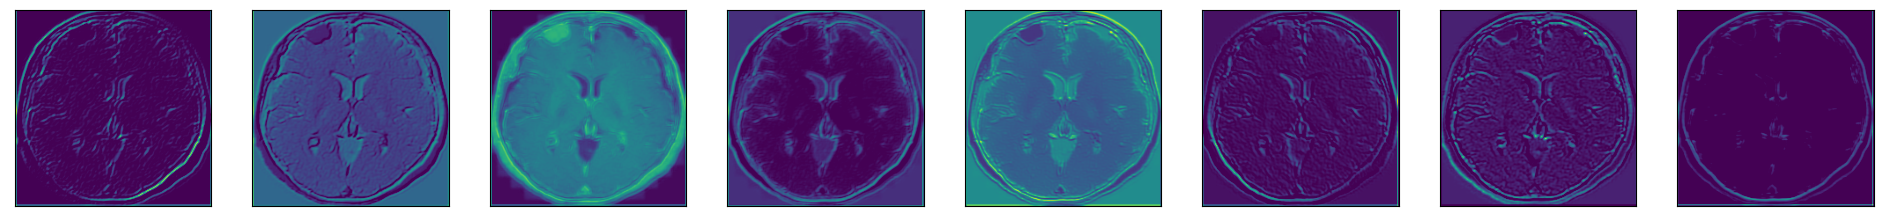

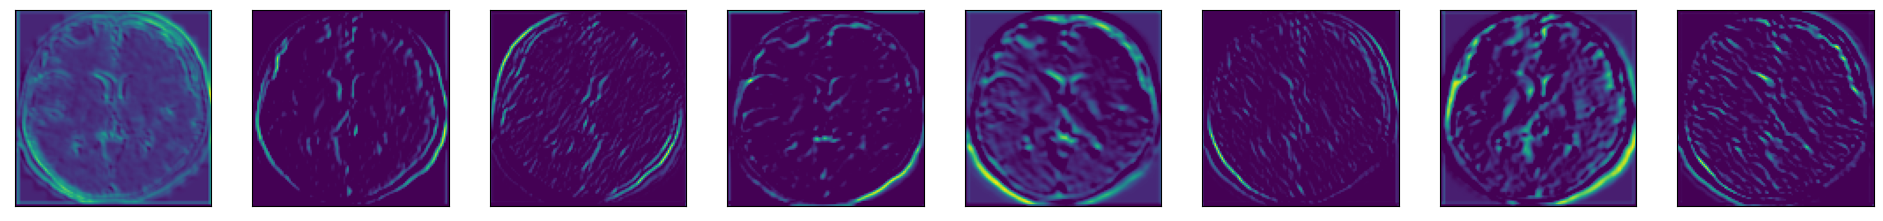

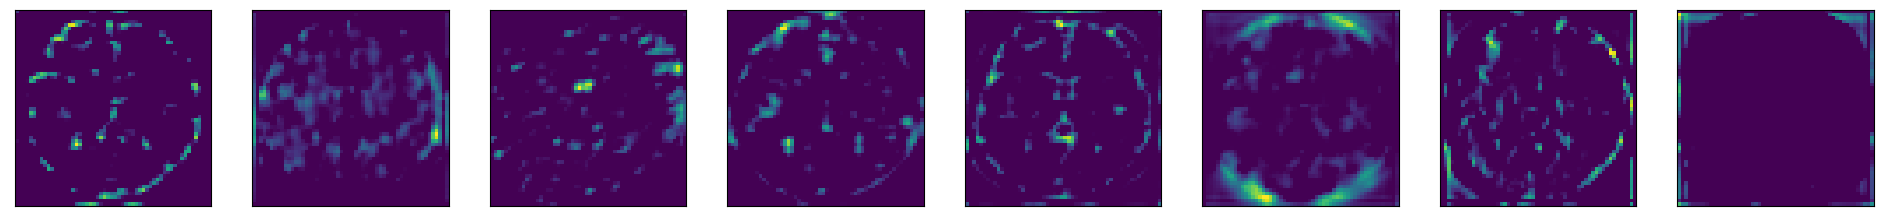

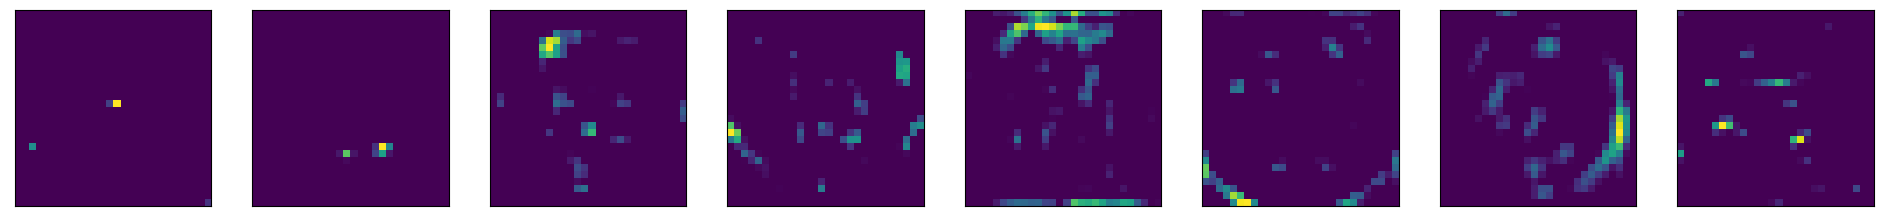

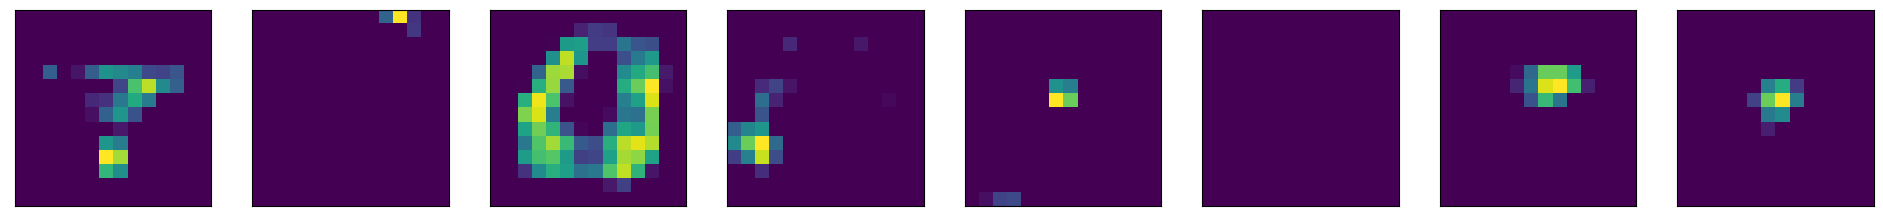

In [30]:
plot_feature_maps(X_val_prep, 15)

In [31]:
start = time.time()

vgg16_history = vgg16.fit(
    train_generator,
    epochs=120,
    validation_data=validation_generator,
    verbose=0,
)

end = time.time()
print(end - start)


2022-12-27 20:52:41.974437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-27 20:52:44.113530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


257.0772511959076


In [35]:
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

_, train_acc = vgg16.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = vgg16.evaluate(X_test_prep, y_test, verbose=0)


2/2 [==============================] - 1s 562ms/step


In [36]:
def plot_vgg16_history(history: dict) -> None:
    """
    Plot the loss and accuracy history of a VGG16 model.

    Parameters:
    history (dict): A dictionary containing the loss and accuracy history of a VGG16 model.
    """
    plt.figure(figsize=(12, 12))
    plt.subplot(211)
    plt.title("Vgg16 Loss")
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.legend()
    plt.subplot(212)
    plt.title("Vgg16 Accuracy")
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.legend()
    plt.show()


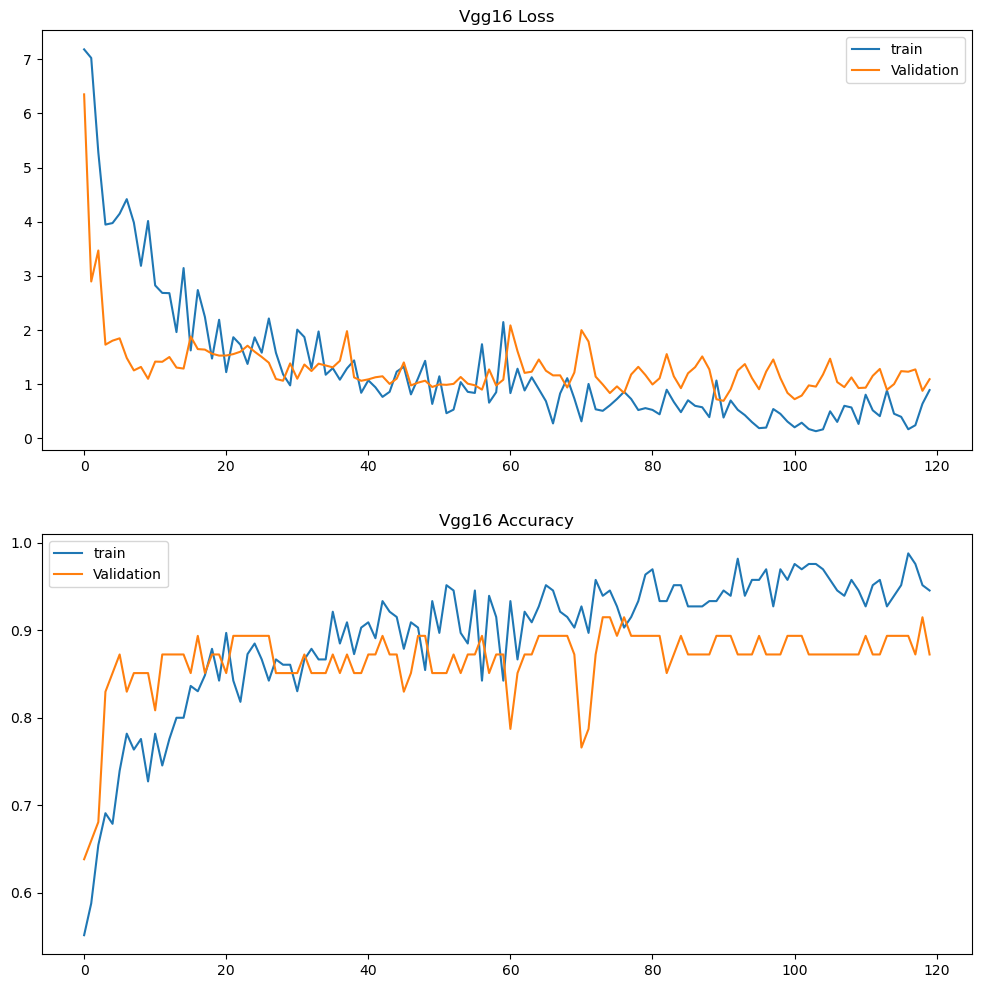

In [37]:
plot_vgg16_history(vgg16_history)

In [41]:
def plot_confusion_matrix(predictions: list, actual_labels: list) -> None:
    """
    Plot a confusion matrix for the given predictions and actual labels.

    Parameters:
    predictions (list): A list of predictions made by a VGG16 model.
    actual_labels (list): A list of the actual labels corresponding to the predictions.
    """
    cm = confusion_matrix(actual_labels, predictions)
    plt.imshow(cm, cmap="Blues")
    # plt.colorbar()
    tick_marks = range(len(set(actual_labels)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.show()


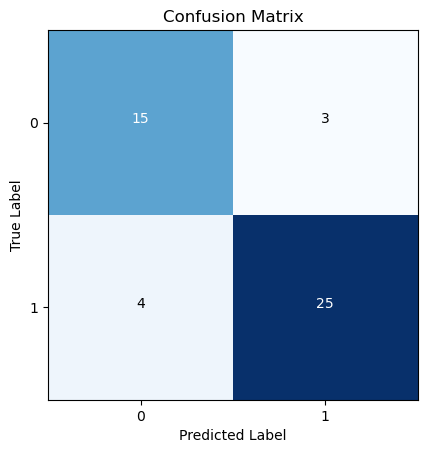

In [42]:
plot_confusion_matrix(predictions, y_test)


In [50]:
def print_evaluation_metrics(predictions: list, actual_labels: list) -> None:
    """
    Print out several evaluation metrics for a classification model.

    Parameters:
    predictions (list): A list of predictions made by a classification model.
    actual_labels (list): A list of the actual labels corresponding to the predictions.
    """
    print("Accuracy:", round(accuracy_score(actual_labels, predictions), 4) * 100, "%")
    print("Precision:", round(precision_score(actual_labels, predictions), 4) * 100, "%")
    print("Recall:", round(recall_score(actual_labels, predictions), 4) * 100, "%")
    print("F1 Score:", round(f1_score(actual_labels, predictions), 4) * 100, "%")


In [51]:
print_evaluation_metrics(predictions, y_test)

Accuracy: 85.11 %
Precision: 89.29 %
Recall: 86.21 %
F1 Score: 87.72 %
